In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from scipy import optimize

import torch
from torch import nn

from utils import get_gaussian_targets
from models import RNN
from train import test_and_get_stats, train_bptt, train_bptt_sparse
from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(93214)
np.random.seed(35107)

In [3]:
# instantiate network
n_inputs, n_hidden, n_outputs = 1, 500, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs)

In [4]:
# instantiate loss function and optimizer
mse_fn = nn.MSELoss()
loss_fn = lambda a, b: mse_fn(a, b) / (b ** 2).mean()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Text(0, 0.5, 'firing rate (a.u.)')

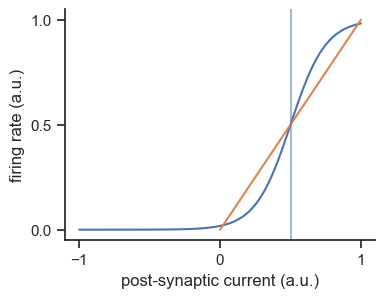

In [5]:
x = torch.linspace(-1, 1, 100)
fig, axes = plt.subplots(1, 1, figsize=(4, 3))
axes.plot(x, model.transfer_func(x,
                                 gain=model.activation_gain,
                                 thresh=model.activation_thresh))
axes.plot([0, 1], [0, 1])
axes.axvline(0.5, c='C0', alpha=0.5)
axes.set_xticks([-1, 0, 1])
axes.set_yticks([0, 0.5, 1])
axes.set_xlabel('post-synaptic current (a.u.)')
axes.set_ylabel('firing rate (a.u.)')

In [6]:
model.transfer_func(torch.tensor([0, 1]))

tensor([0.0180, 0.9820])

In [ ]:
# set parameters
# simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)

In [8]:
# define inputs (for contextual modulation / recurrent perturbations)
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
inputs[:, perturb_win_mask, :] = 0.1
noise_tau = 0.01
noise_std = 0.0

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = torch.zeros(n_hidden)  # steady-state for postsyn activity var
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
r_0 = torch.ones(n_hidden)  # steady-state for depression var
r_0 = torch.tile(r_0, (n_batches, 1))
u_0 = model.p_rel.detach()  # steady-state for facilitation var
u_0 = torch.tile(u_0, (n_batches, 1))

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)
r_0 = r_0.to(device)
u_0 = u_0.to(device)

# move to desired device
model.to(device)

# get initial gain and scale up with each increase in beta
init_gain = model.gain
gain_adjustments_all = list()
# n_beta_steps = [2, 3, 5, 9, 17]
n_beta_steps = [9]
for max_iter in n_beta_steps:
    
    # scale up gain to a resonably good approximation given mean p_rel
    model.gain = init_gain

    # slowly inclrease STP beta param, turning up gain adjustment accordingly
    # max_iter = 30
    beta_step = torch.linspace(0, model.beta, max_iter)
    gain_adjustments = list()
    model.eval()
    for beta_step_idx in range(max_iter):
        model.beta = beta_step[beta_step_idx]
        
        for update_idx in range(2):
            state_vars_, _ = test_and_get_stats(inputs, targets, times,
                                                model, loss_fn, h_0, r_0, u_0,
                                                include_stp=True,
                                                noise_tau=noise_tau,
                                                noise_std=noise_std,
                                                plot=False)
            ext_in_, hidden_sr_t_, r_t_, u_t_, output_sr_t_ = state_vars_
            syn_eff_ = r_t_* u_t_
            gain_adjustment = model.p_rel.mean() / syn_eff_.mean()
            model.gain = init_gain * gain_adjustment
            gain_adjustments.append(gain_adjustment)
        print(f'gain tuning iter: {beta_step_idx}')
    
    gain_adjustments_all.append(gain_adjustments)

Test loss: 6.154509
Test loss: 6.154509
gain tuning iter: 0
Test loss: 6.395271
Test loss: 6.455763
gain tuning iter: 1
Test loss: 5.996925
Test loss: 6.045248
gain tuning iter: 2
Test loss: 5.179660
Test loss: 5.781995
gain tuning iter: 3
Test loss: 5.223061
Test loss: 5.379426
gain tuning iter: 4
Test loss: 5.682727
Test loss: 6.073446
gain tuning iter: 5
Test loss: 5.418121
Test loss: 5.468586
gain tuning iter: 6
Test loss: 5.252205
Test loss: 5.488106
gain tuning iter: 7
Test loss: 4.943773
Test loss: 5.019568
gain tuning iter: 8


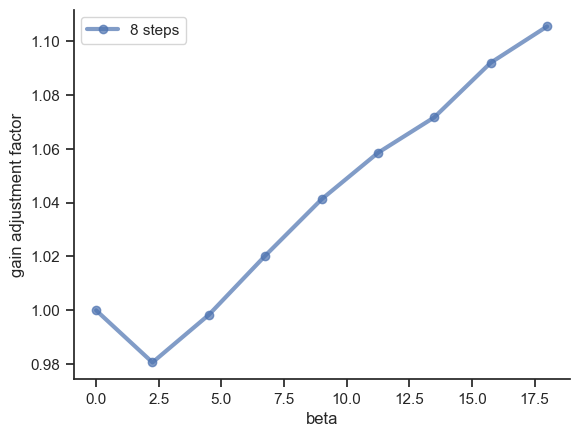

In [9]:
plt.figure()
for idx, gain_adjustments in enumerate(gain_adjustments_all):
    beta = torch.linspace(0, model.beta, n_beta_steps[idx])
    n_intermed_steps = n_beta_steps[idx] - 1
    label = f'{n_intermed_steps} steps'
    plt.plot(beta, gain_adjustments[1::2], '-o', lw=3, alpha=0.7, label=label)
plt.xlabel('beta')
plt.ylabel('gain adjustment factor')
plt.legend()
plt.show()

In [10]:
model.gain.item()

4.8638997077941895

In [11]:
# move to desired device
model.to(device)

# get fixed points
def func_roots(x):
    n_batches = 1
    x = torch.tensor(x, dtype=torch.float32)
    h_0 = x[:n_hidden]
    h_0 = torch.tile(h_0, (n_batches, 1))
    r_0 = x[n_hidden:2 * n_hidden]
    r_0 = torch.tile(r_0, (n_batches, 1))
    u_0 = x[2 * n_hidden:3 * n_hidden]
    u_0 = torch.tile(u_0, (n_batches, 1))
    inputs = torch.zeros((n_batches, 1, n_inputs))

    inputs = inputs.to(device)
    h_0 = h_0.to(device)
    r_0 = r_0.to(device)
    u_0 = u_0.to(device)

    model.eval()
    with torch.no_grad():
        dhdt, drdt, dudt = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt,
                                 return_deriv=True, include_stp=True)

    return torch.concat((dhdt, drdt, dudt))

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = torch.zeros(n_hidden)
r_0 = torch.ones(n_hidden)
u_0 = model.p_rel.detach()
x_0 = torch.concat((h_0, r_0, u_0))
sol = optimize.root(func_roots, x0=x_0, method='hybr')

print(sol.x, sol.nfev, sol.message)

[-0.04117473  0.09835291  0.02588411 ...  0.87956341  0.77531506
  0.95053455] 3028 The solution converged.


0.0037884537869356206


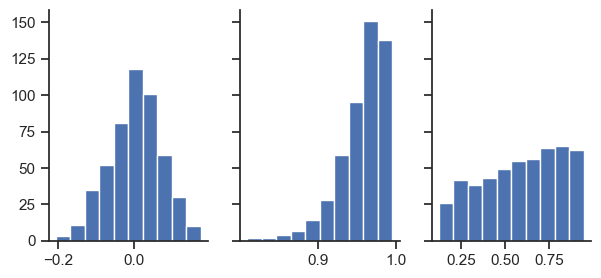

In [12]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(7, 3))
axes[0].hist(sol.x[:n_hidden])
# axes[0].set_xlim([-1, 1])
axes[1].hist(sol.x[n_hidden:2 * n_hidden])
# axes[1].set_xlim([0, 1])
axes[2].hist(sol.x[2 * n_hidden:3 * n_hidden])
# axes[2].set_xlim([0, 1])
print(sol.x[:n_hidden].mean())

Test loss: 8.294270


/tmp/ipykernel_30233/2839993035.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


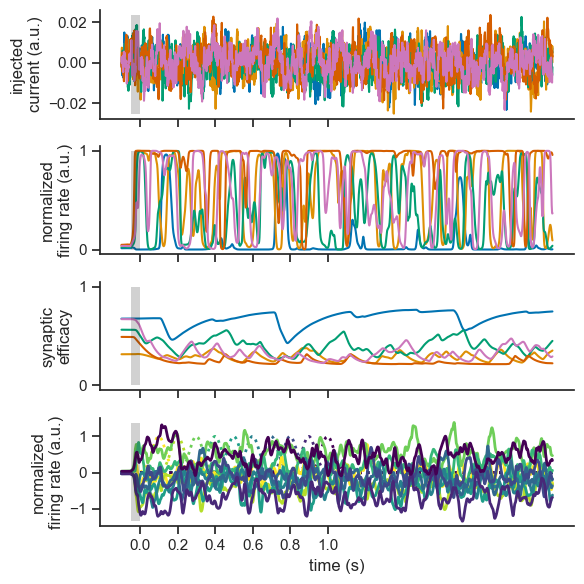

In [22]:
# define inputs (for contextual modulation / recurrent perturbations)
include_stp = True
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
inputs[:, perturb_win_mask, :] = 0.1
noise_tau = 0.01

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
h_0 = torch.tensor(sol.x[:n_hidden], dtype=torch.float32)
# h_0 = torch.zeros(n_hidden)
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
r_0 = torch.tensor(sol.x[n_hidden:2 * n_hidden], dtype=torch.float32)
# r_0 = torch.ones(n_hidden) 
r_0 = torch.tile(r_0, (n_batches, 1))
u_0 = torch.tensor(sol.x[2 * n_hidden:3 * n_hidden], dtype=torch.float32)
# u_0 = model.p_rel.detach()
u_0 = torch.tile(u_0, (n_batches, 1))

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)
r_0 = r_0.to(device)
u_0 = u_0.to(device)

# plot model output before training
noise_std = 1e-1
_, sim_stats_pre = test_and_get_stats(inputs, targets, times,
                                      model, loss_fn, h_0, r_0, u_0,
                                      include_stp=include_stp,
                                      noise_tau=noise_tau,
                                      noise_std=noise_std,
                                      plot=True)

weights_pre = model.gain * model.W_hh * model.presyn_scaling.detach()

# # train model weights
# noise_std = 1e-4
# max_iter = 500
# convergence_reached = False
# loss_per_iter = list()
# for iter_idx in range(max_iter):
#     loss = train_bptt(inputs, targets, times, model, loss_fn, optimizer,
#                       h_0, r_0, u_0, dt=dt, include_stp=include_stp,
#                       noise_tau=noise_tau, noise_std=noise_std)
#     loss_per_iter.append(loss)
#     print(f"Training trial {iter_idx} complete!")

# weights_post = model.gain * model.W_hh * model.presyn_scaling.detach()

# # investigate fitted model
# # plot model output after training
# noise_std = 0.0
# state_vars_post, sim_stats_post = test_and_get_stats(
#     inputs, targets, times, model, loss_fn, h_0, r_0, u_0,
#     include_stp=include_stp, noise_tau=noise_tau, noise_std=noise_std,
#     plot=True)

# ext_in_post, hidden_sr_post, r_post, u_post, output_sr_post = state_vars_post
# loss_per_iter.append(sim_stats_post['loss'])

# # plot loss across training
# fig_learning = plot_learning(np.array(loss_per_iter), max_iter=None)
# # plt.savefig('/home/ryan/Desktop/training_loss_force.png')

In [14]:
from utils import est_dimensionality

def test_and_get_stats(inputs, targets, times, model, loss_fn, h_0, r_0, u_0,
                       include_stp, noise_tau, noise_std, plot=True):
    dt = times[1] - times[0]
    model.eval()

    with torch.no_grad():
        # simulate and calculate total output error
        ext_in, h_t, r_t, u_t, z_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0,
                                           dt=dt, include_stp=include_stp,
                                           noise_tau=noise_tau,
                                           noise_std=noise_std)
        loss = loss_fn(z_t[:, times > 0, :], targets[:, times > 0, :])

    try:
        print(f"Test loss: {loss.item():>7f}")
    except RuntimeError:
        Warning("Test loss isn't a scalar!")

    # select first batch if more than one exists
    # ext_in_batch = ext_in.cpu()[0]
    noise_batch = ext_in.cpu()[0] - inputs.cpu()[0]
    hidden_batch = model.transfer_func(h_t).cpu()[0]
    syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
    outputs_batch = z_t.cpu()[0]
    targets_batch = targets.cpu()[0]

    # visualize network's response
    if plot:
        fig = plot_state_traj(noise=noise_batch, h_units=hidden_batch,
                              syn_eff=syn_eff_batch, outputs=outputs_batch,
                              targets=targets_batch, times=times)
        fig.show()

    # calculate metrics-of-interest
    n_dim = est_dimensionality(hidden_batch)
    psc_std = hidden_batch.mean()
    stats = dict(loss=loss, dimensionality=n_dim, psc_std=psc_std)

    state_vars = (ext_in.cpu(),
                  model.transfer_func(h_t).cpu(),
                  r_t.cpu(),
                  u_t.cpu(),
                  z_t.cpu())

    return state_vars, stats


In [15]:
from matplotlib.patches import Rectangle
from cycler import cycler

def plot_state_traj(noise, h_units, syn_eff, outputs, targets, times):
    # NB: assumes a single batch/trial
    n_times, n_hidden = h_units.shape
    n_outputs = outputs.shape[1]

    time_mask = times > 0
    times_after_zero = times[time_mask]

    n_hidden_plot = 5  # number of hidden units to plot
    if n_hidden < 5:
        n_hidden_plot = n_hidden

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 6))

    # create colormaps
    cm_hidden = sns.color_palette('colorblind')
    cm_output = plt.cm.viridis_r(np.linspace(0, 1, n_outputs))

    # injected current
    axes[0].set_prop_cycle(cycler('color', cm_hidden))
    axes[0].plot(times, noise[:, :n_hidden_plot])
    noise_lb = noise[:, :n_hidden_plot].min()
    noise_ub = noise[:, :n_hidden_plot].max()
    rec_height = noise_ub - noise_lb
    axes[0].add_patch(Rectangle([-0.05, noise_lb], 0.05, rec_height,
                                ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[0].set_ylabel('injected\ncurrent (a.u.)')
    # axes[0].set_yticks([0, 1])

    # recurrent unit trajectories
    axes[1].set_prop_cycle(cycler('color', cm_hidden))
    axes[1].plot(times, h_units[:, :n_hidden_plot])
    axes[1].add_patch(Rectangle([-0.05, 0], 0.05, 1.0, ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[1].set_ylabel('normalized\nfiring rate (a.u.)')
    axes[1].set_yticks([0, 1])

    # synaptic utilization (from STP)
    axes[2].set_prop_cycle(cycler('color', cm_hidden))
    axes[2].plot(times, syn_eff[:, :n_hidden_plot])
    axes[2].add_patch(Rectangle([-0.05, 0], 0.05, 1.0, ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[2].set_ylabel('synaptic\nefficacy')
    axes[2].set_yticks([0, 1])

    # outputs
    axes[3].set_prop_cycle(cycler('color', cm_output))
    axes[3].plot(times_after_zero, targets[time_mask, :], lw=2, ls=':')
    axes[3].plot(times, outputs, lw=2)
    output_lb = outputs.min()
    output_ub = outputs.max()
    rec_height = output_ub - output_lb
    axes[3].add_patch(Rectangle([-0.05, output_lb], 0.05, rec_height,
                                ec='none', fc='k',
                                alpha=0.2, zorder=100))
    axes[3].set_xticks(np.arange(0, 1.2, 0.2))
    axes[3].set_xlabel('time (s)')
    axes[3].set_ylabel('normalized\nfiring rate (a.u.)')
    axes[3].set_yticks([-1, 0, 1])

    fig.tight_layout()

    return fig

In [ ]:
.8858   .9518

In [ ]:
weights_pre

tensor([[-0.0197, -0.5614, -0.9141,  ...,  0.9472, -0.7936, -1.6450],
        [-0.2943, -0.1525,  0.1633,  ...,  0.0420,  0.5569,  0.5900],
        [-0.0110,  0.3164,  0.1010,  ...,  0.7382,  0.2228, -0.4012],
        ...,
        [ 1.1197, -1.0611, -0.0621,  ..., -0.4874,  0.7613,  0.5321],
        [-0.5284,  0.2151, -1.1365,  ...,  0.3684,  0.5075, -0.7470],
        [-0.5107, -0.0666, -0.0961,  ..., -0.2210, -0.5329,  0.2292]])

In [10]:
model.offset_hz

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

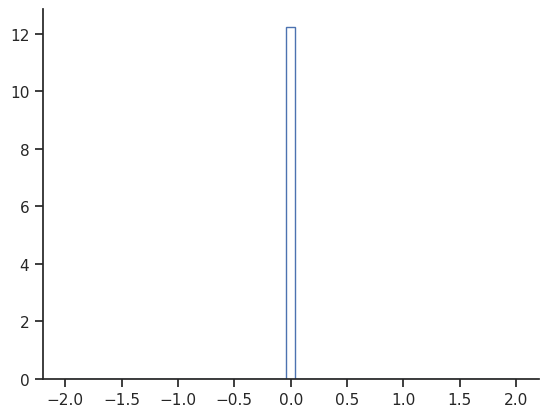

In [ ]:
bins = np.linspace(-2, 2, 50)

fig = plt.figure()
# plt.hist(weights_0.detach().flatten(), bins=bins, density=True, histtype='step', fill=True, alpha=0.5)
# plt.hist(weights_1.detach().flatten(), bins=bins, density=True, histtype='step', fill=True, alpha=0.5)
plt.hist(weights_post.detach().flatten() - weights_pre.detach().flatten(), bins=bins, density=True, histtype='step', fill=False)
plt.show()

In [21]:
def f_prime(x, gain=8.0, thresh=0.5):
    exp_term = torch.exp(-gain * (x - thresh))
    return gain * exp_term / (1 + exp_term) ** 2

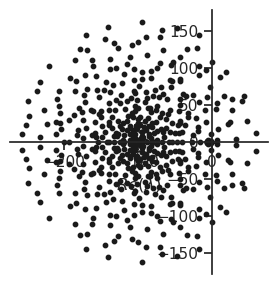

In [ ]:
angles = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7, 3))

h_0 = torch.tensor(sol.x[:n_hidden], dtype=torch.float32)
r_0 = torch.tensor(sol.x[n_hidden:2 * n_hidden], dtype=torch.float32)
u_0 = torch.tensor(sol.x[2 * n_hidden:3 * n_hidden], dtype=torch.float32)

jacobian_h = torch.cat((
    (-torch.eye(model.n_hidden) + weights_pre * r_0 * u_0 * f_prime(h_0)) / model.tau,
    weights_pre * u_0 * model.transfer_func(h_0) / model.tau,
    weights_pre * r_0 * model.transfer_func(h_0) / model.tau
), dim=1)

jacobian_r = torch.cat((
    torch.diag(-model.beta * r_0 * u_0 * f_prime(h_0)),
    torch.diag(-(1 / model.tau_depr + model.beta * u_0 * model.transfer_func(h_0))),
    torch.diag(-model.beta * r_0 * model.transfer_func(h_0))
), dim=1)

jacobian_u = torch.cat((
    torch.diag(model.beta * model.p_rel * (1 - u_0) * f_prime(h_0)),
    torch.zeros((model.n_hidden, model.n_hidden)),
    torch.diag(-(1 / model.tau_facil + model.beta * model.p_rel * model.transfer_func(h_0)))
), dim=1)

jacobian_full = torch.cat((jacobian_h, jacobian_r, jacobian_u), dim=0)
eigvals_0, eigvecs_0 = scipy.linalg.eig(jacobian_full)
# ax.axvline(0, c='r')
ax.scatter(eigvals_0.real, eigvals_0.imag, c='k', s=10)
# ax.set_title('pre-training')
# ax.set_xticks([])
ax.set_xlabel(r'$Re(\lambda)$')
# ax.set_yticks([])
ax.set_ylabel(r'$Im(\lambda)$')

ax.set_aspect('equal')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
fig.tight_layout()

(array([  0.,   0.,   0.,   0.,   0.,   6.,   3.,   9.,  14.,   6.,  14.,
         12.,  25.,  11.,  23.,  24.,  22.,  24.,  23.,  38.,  27.,  29.,
         24.,  23.,  16.,  29.,  11.,  16.,  17.,  12.,  12.,   9.,  13.,
          4.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0., 500.]),
 array([-120., -119., -118., -117., -116., -115., -114., -113., -112.,
        -111., -110., -109., -108., -107., -106., -105., -104., -103.,
        -102., -101., -100.,  -99.,  -98.,  -97.

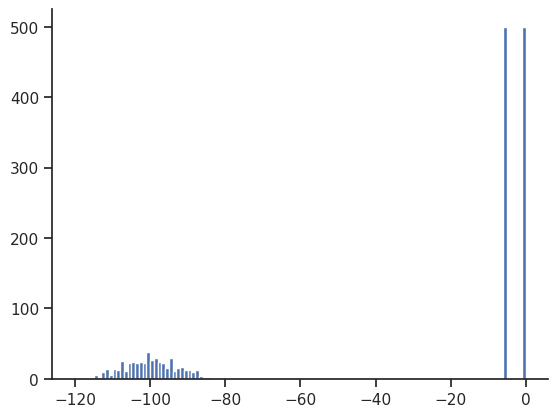

In [34]:
eigvals_real_sorted = np.sort(eigvals_0.real)
plt.figure()
plt.hist(eigvals_real_sorted, bins=np.linspace(-120, 0, 121))

In [ ]:
# weights = model.W_hh * model.presyn_scaling.detach() * model.p_rel
angles = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3))

jacobian_0 = (weights_pre * f_prime(0) * model.p_rel - torch.eye(model.n_hidden)) / model.tau
eigvals_0, eigvecs_0 = scipy.linalg.eig(jacobian_0)
# ax[0].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[0].scatter(eigvals_0.real, eigvals_0.imag, c='k', s=10)
ax[0].set_title('pre-training')

jacobian_1 = (weights_post * f_prime(0) * model.p_rel - torch.eye(model.n_hidden)) / model.tau
eigvals_1, eigvecs_1 = scipy.linalg.eig(jacobian_1)
# ax[1].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[1].scatter(eigvals_1.real, eigvals_1.imag, c='k', s=10)
ax[1].set_title('post-training')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].spines['left'].set_position('zero')
ax[0].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_position('zero')
ax[1].spines['bottom'].set_position('zero')
ax[1].set_yticks([])
ax[1].set_xticks([])

SyntaxError: invalid syntax (2722753663.py, line 11)

In [ ]:
sim_stats_pre['dimensionality']

3.3300537560216683

In [ ]:
sim_stats_post['dimensionality']

3.714206065600773

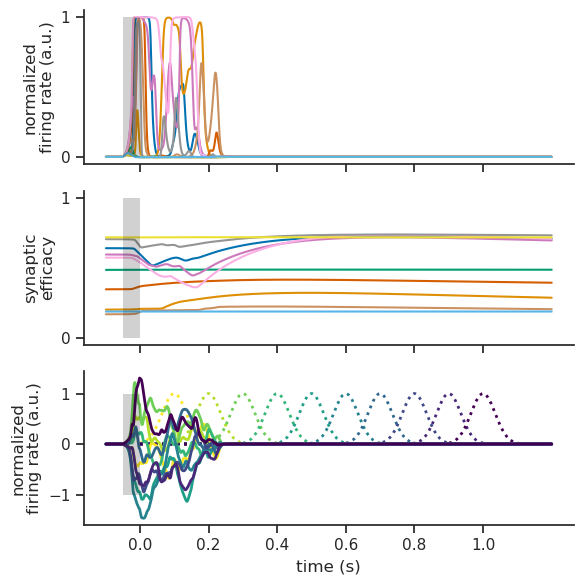

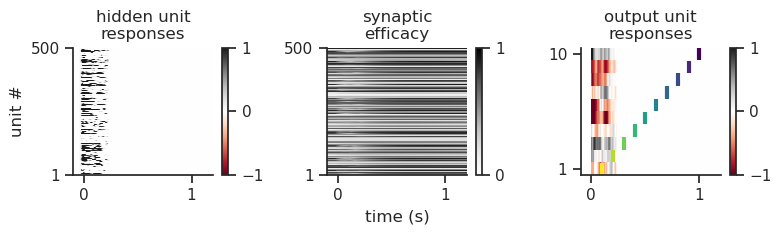

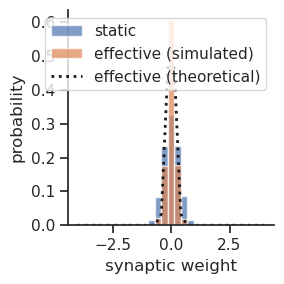

In [19]:
# plot sim of current model
model.eval()

with torch.no_grad():
    h_t, r_t, u_t, z_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt)

weights = model.W_hh * model.presyn_scaling.detach()
prob_c = float(torch.count_nonzero(model.W_hh_mask) /
               torch.numel(model.W_hh_mask))

# select first batch if more than one exists
hidden_batch = model.transfer_func(h_t).cpu()[0]
syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
outputs_batch = z_t.cpu()[0]
targets_batch = targets.cpu()[0]

fig_traj = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                           syn_eff=syn_eff_batch,
                           targets=targets_batch, times=times)

fig_all_units = plot_all_units(h_units=hidden_batch, syn_eff=syn_eff_batch,
                               outputs=outputs_batch,
                               targets=targets_batch, times=times)

fig_weights_distr = plot_weight_distr(weights, model.W_hh_mask,
                                      syn_eff_batch,
                                      eff_gain=model.effective_gain,
                                      true_gain=model.gain.detach(),
                                      prob_c=prob_c)
plt.show()

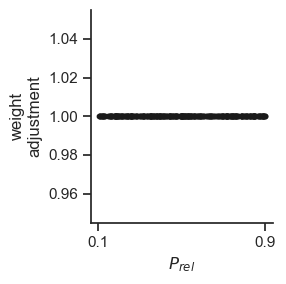

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
# sort_idxs = np.argsort(model.p_rel.detach().numpy())
p_rel = model.p_rel.detach().numpy()
post_syn_adjustment = model.presyn_scaling.detach().numpy()
axes.scatter(p_rel, post_syn_adjustment, s=10, c='k')
axes.set_xticks([0.1, 0.9])
axes.set_xlabel('$P_{rel}$')

# axes.set_yticks([0, np.max(post_syn_adjustment).round(decimals=1)])
axes.set_ylabel('weight\nadjustment')
fig.tight_layout()

In [ ]:
dhdh_t_batch = dhdh_t[0].cpu()
dh

(array([  49,   50,   51, ..., 1197, 1198, 1199]),)

In [ ]:
dhdh_t[0, -1, :]

tensor([  0.9232,   1.0039,   1.2146,   1.3067,   0.9179,   1.0058,   1.0219,
          1.0163,   1.0436,   1.0001,   0.9882,   1.1612,   0.9773,   0.9267,
          0.8346,   1.1503,   0.9197,   0.9877,   0.9204,   0.9194,   0.9452,
          1.0295,   0.9818,   0.8892,   1.0304,   0.7978,   0.9148,   1.0383,
          1.0854,   1.0169,   0.7829,   1.0479,   0.9629,   0.9584,   0.9868,
          1.1023,   1.0036,   0.9416,   0.9267,   1.0120,   1.0309,   0.9113,
          0.8620,   0.9551,   1.1825,   0.9548,   0.8753,   1.0712,   0.8548,
          0.9585,   2.1194,   0.9243,   1.0159,  10.2229,   0.9236,   0.8809,
          0.8873,   1.0230,   1.3648,   0.9888,   0.9411,   1.0019,   1.2520,
          1.1657,   1.0497,   0.9282,   0.8071,   1.1096,   1.0269,   1.7131,
          1.0088,   0.5928,   0.2820,   0.9902,   0.8446,   1.0481,   0.9247,
          1.0056,   0.8987,   1.1063,   0.8528,   0.8027,   0.9392,   0.9946,
          0.7353,   0.9762,   1.0957,   0.9989,   1.4460,   1.16

In [ ]:
fig_traj.savefig('/home/ryan/Desktop/traj_gain_scaled_hz_nonforce_postlearning.png')
fig_all_units.savefig('/home/ryan/Desktop/units_all_gain_scaled_hz_nonforce_postlearning.png')
fig_weights_distr.savefig('/home/ryan/Desktop/hidden_weights_gain_scaling_postlearning.png')